In [1]:
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options
import numpy as np
import sys
import gamspy as gp
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt


In [2]:
# Fetch the list of S&P 500 companies from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]  # The first table on the page is the list of S&P500 companies
tickers = sp500_table["Symbol"].tolist()

# Clean up tickers if needed (e.g., remove special cases like 'BRK.B' or replace with 'BRK-B')
tickers = [ticker.replace('.', '-') for ticker in tickers]

# Fetch historical stock data for the past year
data = yf.download(tickers, start="2023-09-30", end="2024-10-31")["Adj Close"]

# Resample to monthly data (mid-market prices at the last trading day of each month)
monthly_data = data.resample('M').last()

# Ensure we get exactly the last 12 months
monthly_data = monthly_data.tail(13)

# Convert to NumPy array (12 rows for months, number of stocks columns)
prices_array = monthly_data.to_numpy()

# Transpose to get rows = stocks and columns = months
prices_array = prices_array.T

# Check the shape for verification
print("Shape:", prices_array.shape)  # Should be (number_of_stocks, 12)


[*********************100%***********************]  503 of 503 completed
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_14888\1628395829.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').last()


Shape: (503, 13)


In [78]:
import numpy as np

# Assuming prices_array is already defined as a (499, 13) numpy array
# For example, you can simulate one with:
# prices_array = np.random.rand(499, 13) * 100  # Replace with your actual data

# Calculate percentage growth for each row
percentage_growth = ((prices_array[:, -1] - prices_array[:, 0]) / prices_array[:, 0]) * 100

# Count the number of rows with growth greater than 5%
rows_with_growth_above_5_percent = np.sum(percentage_growth > 4.5)

print(f"Number of rows with more than 5% growth: {rows_with_growth_above_5_percent}")


Number of rows with more than 5% growth: 427


In [79]:
437/500

0.874

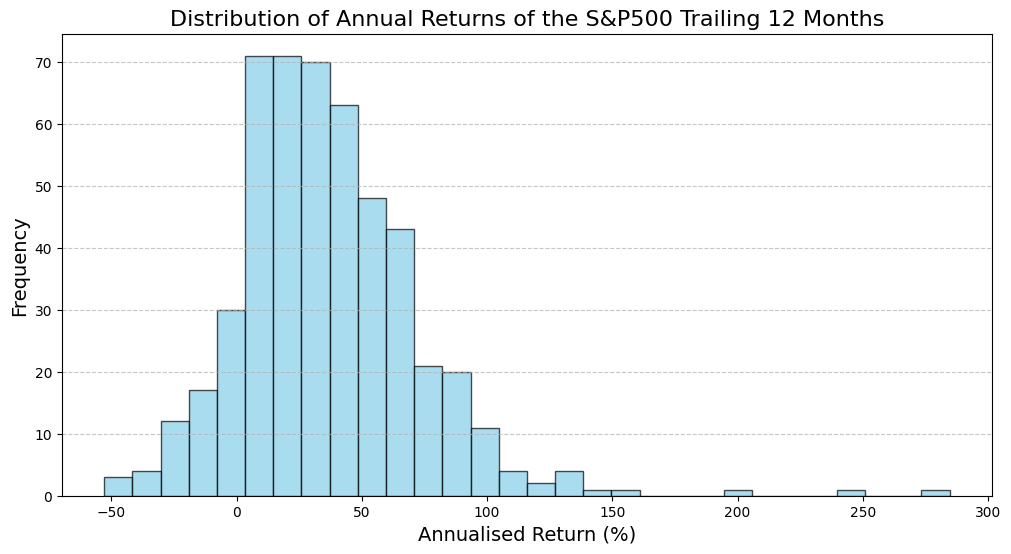

In [77]:
import matplotlib.pyplot as plt

# Create a histogram of growth rates
plt.figure(figsize=(12, 6))
plt.hist(percentage_growth, bins=30, edgecolor='k', alpha=0.7, color='skyblue')
plt.title('Distribution of Annual Returns of the S&P500 Trailing 12 Months', fontsize=16)
plt.xlabel('Annualised Return (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as a transparent, high-DPI SVG
plt.savefig('annual_returns_distribution.svg', format='svg', dpi=300, transparent=True)

# Display the plot
plt.show()


In [3]:

def find_invalid_rows(array):
    """
    Identifies rows with zeros or NaN values in a 2D array.
    
    Parameters:
        array (list or np.ndarray): A 2D nested list or numpy array.
    
    Returns:
        list: Indices of rows with zeros or NaN values.
    """
    invalid_indices = []
    for i, row in enumerate(array):
        if any(value == 0 or (isinstance(value, float) and math.isnan(value)) for value in row):
            invalid_indices.append(i)
    return invalid_indices

def remove_invalid_data(prices, tickers):
    """
    Removes rows with zeros or NaN values from the prices array and their corresponding tickers.
    
    Parameters:
        prices (np.ndarray): The prices array (2D).
        tickers (list): The list of tickers corresponding to rows of the prices array.
    
    Returns:
        tuple: Filtered prices array and tickers list.
    """
    invalid_indices = find_invalid_rows(prices)
    
    # Filter prices and tickers
    valid_prices = np.delete(prices, invalid_indices, axis=0)
    valid_tickers = [ticker for i, ticker in enumerate(tickers) if i not in invalid_indices]
    
    return valid_prices, valid_tickers

# Example usage
prices_array = np.array(prices_array)  # Ensure it's a numpy array
filtered_prices, filtered_tickers = remove_invalid_data(prices_array, tickers)

# Update the original variables if needed
prices_array = np.array(filtered_prices)
tickers = np.array(filtered_tickers)

print("Filtered Prices Array:", prices_array.shape)
print("Filtered Tickers:", tickers.shape)


Filtered Prices Array: (499, 13)
Filtered Tickers: (499,)


In [67]:
# Portfolio Configuration Parameters
max_exposure = 0.15  # Maximum exposure per stock
buy_exposure = 0.10  # Maximum buying limit as a fraction of NAV
max_return = 1.80  # Cap on maximum return per stock
PT = 0.32  # Portfolio turnover rate
cash_min = 0.001  # Minimum cash position as a fraction of NAV
bfee = 1.01  # Buy fee multiplier
sfee = 0.99  # Sell fee multiplier
min_buy = 0.001  # Minimum purchase amount
expected_return = 1.478  # Target return for the portfolio
init_cash = 1000000  # Initial cash balance
eps = 0.0001
M = 100000000

buy_minimum = 40000


# Define the model container
m = Container()

# Sets
time_index = 13  # Total number of time periods
stocks = Set(container=m, name="stocks", records=tickers)  # Set of stocks
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))  # Time periods
subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))  # Excludes first period
subtime2 = Set(container=m, domain=time, records=np.arange(2, time_index, 1))  # Excludes first two periods

# Data: Stock prices indexed by stocks and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)

# Variables
C = Variable(container=m, name="C", domain=time, type="Positive")  # Cash balance
V = Variable(container=m, name="V", domain=time, type="Positive")  # Net Asset Value
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")  # Holdings
x.fx[stocks, '0'] = 0  # No initial holdings

b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")  # Stocks bought
b.fx[stocks, '0'] = 0  # No initial buying
#b.lo[stocks, subtime] = 100  # Minimum buying threshold

s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")  # Stocks sold

Z = Variable(container=m, name="Z", type="free")  # Objective variable
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")  # Total sales
Br = Variable(container=m, name="Br", domain=[stocks], type="SemiCont")  # Total purchases
Br.lo[stocks, subtime] = 100 
profit = Variable(container=m, name="profit", domain=[stocks], type="Positive")  # Profit per stock

## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")

## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= 1000000 * omega_trades[stocks]
)



## Determination of omega_trades for stock i
omega_trades_max = Equation(
    m,
    name="omega_trades_max",
    domain=[stocks],
    description="Determines the maximum number of stocks that can be bought"
)
omega_trades_max[stocks] = (
    Br[stocks] >= buy_minimum * omega_trades[stocks]
)



# Equations: Total sales and purchases
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Total revenue from selling stock",
)
total_sales[stocks] = Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time])

total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Total cost from buying stock",
)
total_purchases[stocks] = Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time])

# Profit calculation
pnl = Equation(
    m,
    name="pnl",
    domain=[stocks],
    description="Calculate profit for each stock",
)
pnl[stocks] = (
    profit[stocks] ==
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) - Br[stocks]
)

# Turnover constraint
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="Portfolio turnover calculation",
)
portfolio_turnover[...] = (
    PT * (V["1"] + V[str(time_index - 1)]) >=
    Sum(stocks, Sum(subtime2, b[stocks, subtime2] * prices[stocks, subtime2])) * 2
)

# Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="Cap on maximum returns per stock",
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) <=
    Br[stocks] * max_return
)

# Holdings and cash balance equations
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Holdings balance over time",
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
)

holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial stock holdings",
)
holdings_balance_initial[stocks] = x[stocks, "0"] == 0

cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Cash balance at each time period",
)
cash_balance[time] = (
    C[time] == C[time - 1] -
    Sum(stocks, prices[stocks, time] * bfee * b[stocks, time]) +
    Sum(stocks, prices[stocks, time] * sfee * s[stocks, time])
)

cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance",
)
cash_balance_initial[...] = C["0"] == init_cash

# NAV calculation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Net Asset Value calculation",
)
nav[time] = V[time] == C[time] + Sum(stocks, prices[stocks, time] * x[stocks, time])

# Risk constraints
risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks, time],
    description="Limit position exposure",
)
risk_constraint[stocks, time] = max_exposure * V[time] >= prices[stocks, time] * x[stocks, time]

buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks, time],
    description="Limit buying exposure",
)
buy_risk_constraint[stocks, time] = buy_exposure * V[time] >= prices[stocks, time] * b[stocks, time]

# Deviation and objective function
Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus", type="Positive")
constraint_deviation = Equation(
    container=m,
    name="constraint_deviation",
)
constraint_deviation[...] = (
    Sum(stocks, omega[stocks]) == Z_plus #- Z_minus
)


# Deviation and objective function
portfolio_returns = Equation(
    container=m,
    name="portfolio_returns",
)
portfolio_returns[...] = (
    V[str(time_index - 1)] - expected_return * init_cash  == 0
)




obj_function = Equation(
    container=m,
    name="obj_function",
)
obj_function[...] = Z == Z_plus + Z_minus

# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=Z,
)

# Solve the model
gdx_path = m.gdxOutputPath()
b1.solve(
    output=sys.stdout,
    options=Options(report_solution=1),
    solver_options={
        "reslim": "100",
        # "SolnPoolReplace": 2,
        # "SolnPoolPop": 2,
        # "PopulateLim": 1000,
        # "solnpoolmerge": "mysol.gdx",
    }
)


--- Job _abb84046-a5a9-4fd3-b735-d574f05f2075.gms Start 12/05/24 20:30:16 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MIP CPLEX
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\_abb84046-a5a9-4fd3-b735-d574f05f2075.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\_abb84046-a5a9-4fd3-b735-d574f05f2075.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\tmpt3oq34jx\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\_abb84046-a5a9-4fd3-b735-d574f05f2075.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX C:\Users\SARANG~1\AppData\Local\Temp\tmp0k08m921\_abb84046-

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,40.0000000227037,23484,21985,MIP,CPLEX,15.391


In [1]:
omega_trades.records.level.sum()

NameError: name 'omega_trades' is not defined

In [73]:
b.records[b.records.stocks == "PG"]

,stocks,time,level,marginal,lower,upper,scale
4914,PG,0,0.000000,NaN,0.0,0.0,1.0
4915,PG,1,211.539483,NaN,0.0,inf,1.0
4916,PG,2,0.000000,NaN,0.0,inf,1.0
4917,PG,3,0.000000,NaN,0.0,inf,1.0
4918,PG,4,0.000000,NaN,0.0,inf,1.0
4919,PG,5,0.000000,NaN,0.0,inf,1.0
4920,PG,6,0.000000,NaN,0.0,inf,1.0
4921,PG,7,0.000000,NaN,0.0,inf,1.0
4922,PG,8,0.000000,NaN,0.0,inf,1.0
4923,PG,9,0.000000,NaN,0.0,inf,1.0


In [58]:
pnl = profit.records.level / Br.records.level

#pnl = pnl[pnl != 0].dropna()

N = 0.045

greater_than_N = np.sum(pnl > N)
less_than_N = np.sum(pnl < N)
print(greater_than_N)
print(less_than_N)
greater_than_N/(less_than_N+ greater_than_N)

13
2


np.float64(0.8666666666666667)

In [42]:
pnl

19     0.800000
25     0.800000
49     0.800000
77     0.800000
105    0.800000
133    0.800000
162    0.800000
190    0.800000
218    0.800000
247    0.800000
275    0.800000
304    0.800000
332    0.800000
343    0.271146
344    0.079383
358    0.800000
386    0.800000
415    0.800000
444    0.800000
472    0.800000
Name: level, dtype: float64

In [14]:
pnl.isna().sum()

np.int64(22)

In [27]:
np.sum(pnl < 0)

np.int64(1)

In [116]:
profit.records['level']/Br.records['level']

0      0.000000
1      0.159062
2      0.112690
3      0.000000
4      0.048395
         ...   
494    0.112723
495    0.035499
496    0.000000
497    0.235230
498    0.070095
Name: level, Length: 499, dtype: float64

In [61]:
import pandas as pd

# Load the Excel workbook
file_name = "mysol_export.xlsx"
sheet1_data = pd.read_excel(file_name, sheet_name=0)
# Handle merged cells in sheet1: repeat entries in the first column
sheet1_data.iloc[:, 0] = sheet1_data.iloc[:, 0].fillna(method='ffill')
sheet1_data.rename(columns={sheet1_data.columns[0]: 'solution', sheet1_data.columns[1]: 'stock'}, inplace=True)
print(sheet1_data)


             solution stock  value
0          soln_b1_p1   MMM    0.0
1          soln_b1_p1   AOS    0.0
2          soln_b1_p1   ABT    0.0
3          soln_b1_p1  ABBV    0.0
4          soln_b1_p1   ACN    0.0
...               ...   ...    ...
544404  soln_b1_p1091   XYL    0.0
544405  soln_b1_p1091   YUM    0.0
544406  soln_b1_p1091  ZBRA    0.0
544407  soln_b1_p1091   ZBH    0.0
544408  soln_b1_p1091   ZTS    0.0

[544409 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_7500\2878081250.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sheet1_data.iloc[:, 0] = sheet1_data.iloc[:, 0].fillna(method='ffill')


In [62]:

sheet2_data = pd.read_excel(file_name, sheet_name=1)
# Handle merged cells in sheet1: repeat entries in the first column
sheet2_data.iloc[:, 0] = sheet2_data.iloc[:, 0].fillna(method='ffill')
sheet2_data.rename(columns={sheet2_data.columns[0]: 'solution', sheet2_data.columns[1]: 'stock'}, inplace=True)
print(sheet2_data)



             solution stock  value
0          soln_b1_p1   MMM    0.0
1          soln_b1_p1   AOS    0.0
2          soln_b1_p1   ABT    0.0
3          soln_b1_p1  ABBV    0.0
4          soln_b1_p1   ACN    0.0
...               ...   ...    ...
544404  soln_b1_p1091   XYL    0.0
544405  soln_b1_p1091   YUM    0.0
544406  soln_b1_p1091  ZBRA    0.0
544407  soln_b1_p1091   ZBH    0.0
544408  soln_b1_p1091   ZTS    0.0

[544409 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_7500\3529578726.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sheet2_data.iloc[:, 0] = sheet2_data.iloc[:, 0].fillna(method='ffill')


In [64]:
df_merged

,solution,stock,value_buy,value_profit,profit_percentage,above_threshold
0,soln_b1_p1,MMM,0.0,0.0,NaN,False
1,soln_b1_p1,AOS,0.0,0.0,NaN,False
2,soln_b1_p1,ABT,0.0,0.0,NaN,False
3,soln_b1_p1,ABBV,0.0,0.0,NaN,False
4,soln_b1_p1,ACN,0.0,0.0,NaN,False
...,...,...,...,...,...,...
544404,soln_b1_p1091,XYL,0.0,0.0,NaN,False
544405,soln_b1_p1091,YUM,0.0,0.0,NaN,False
544406,soln_b1_p1091,ZBRA,0.0,0.0,NaN,False
544407,soln_b1_p1091,ZBH,0.0,0.0,NaN,False


In [67]:
df_merged = pd.merge(sheet1_data, sheet2_data, on=['solution', 'stock'], suffixes=('_buy', '_profit'))
# Calculate Profit Percentage
df_merged['profit_percentage'] = (df_merged['value_profit'] / df_merged['value_buy']) * 100
df_merged = df_merged.dropna()

# Define Threshold
threshold = 0.05

# Classify Above/Below Threshold
df_merged['above_threshold'] = df_merged['profit_percentage'] > threshold

# Calculate Proportion Per Solution
summary = df_merged.groupby('solution').apply(
    lambda x: {
        'above_count': x['above_threshold'].sum(),
        'below_count': (~x['above_threshold']).sum(),
        'proportion': x['above_threshold'].sum() / len(x)  # Proportion of above threshold
    }
).apply(pd.Series)

print(summary)

               above_count  below_count  proportion
solution                                           
soln_b1_p1            15.0          0.0    1.000000
soln_b1_p10           15.0          2.0    0.882353
soln_b1_p100          21.0          1.0    0.954545
soln_b1_p1000         37.0          3.0    0.925000
soln_b1_p1001         37.0          3.0    0.925000
...                    ...          ...         ...
soln_b1_p995          31.0          4.0    0.885714
soln_b1_p996          37.0          3.0    0.925000
soln_b1_p997          37.0          3.0    0.925000
soln_b1_p998          37.0          3.0    0.925000
soln_b1_p999          37.0          3.0    0.925000

[1091 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_7500\3506702597.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_merged.groupby('solution').apply(


In [68]:
ratios = summary.proportion

In [69]:
# Calculate statistics
mean_ratio = ratios.mean()
median_ratio = ratios.median()
min_ratio = ratios.min()
max_ratio = ratios.max()

# Output statistics
print(f"Mean ratio: {mean_ratio}")
print(f"Median ratio: {median_ratio}")
print(f"Minimum ratio: {min_ratio}")
print(f"Maximum ratio: {max_ratio}")

Mean ratio: 0.9097519732332914
Median ratio: 0.90625
Minimum ratio: 0.75
Maximum ratio: 1.0


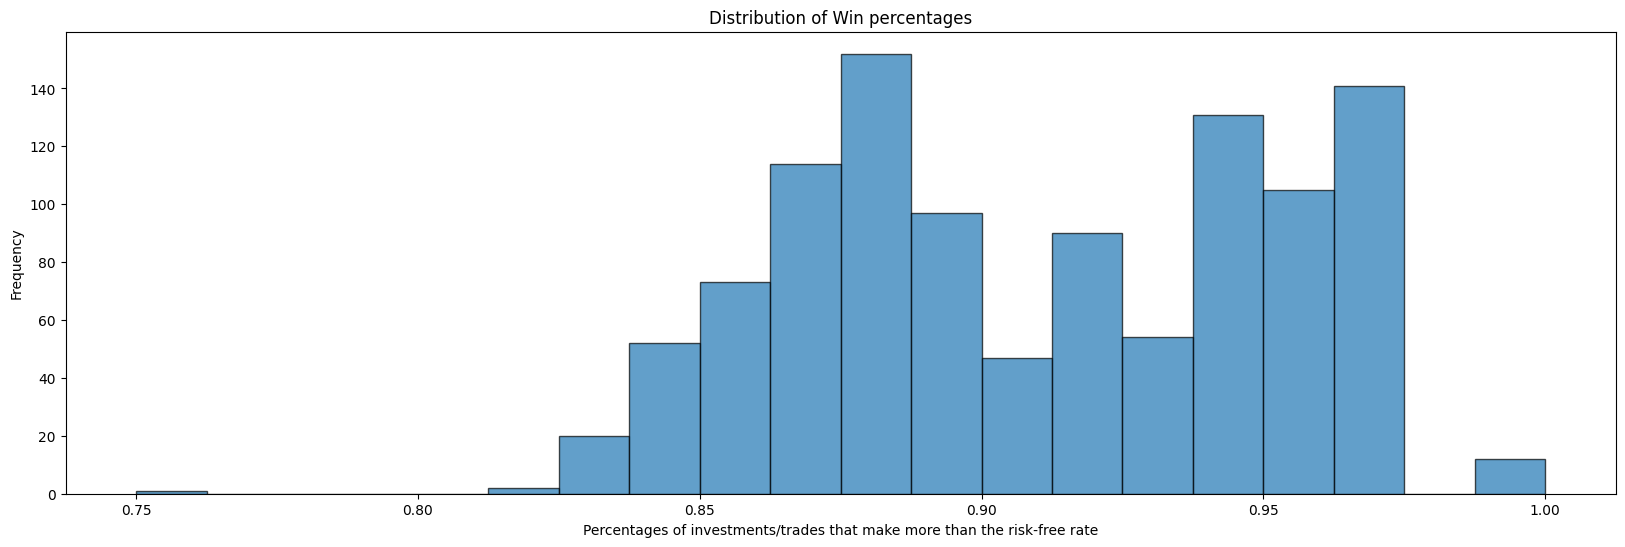

In [72]:
import matplotlib.pyplot as plt

# Plot the distribution of ratios as a histogram
plt.figure(figsize=(20, 6))
plt.hist(ratios, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Win percentages')
plt.xlabel('Percentages of investments/trades that make more than the risk-free rate')
plt.ylabel('Frequency')
plt.show()


# 

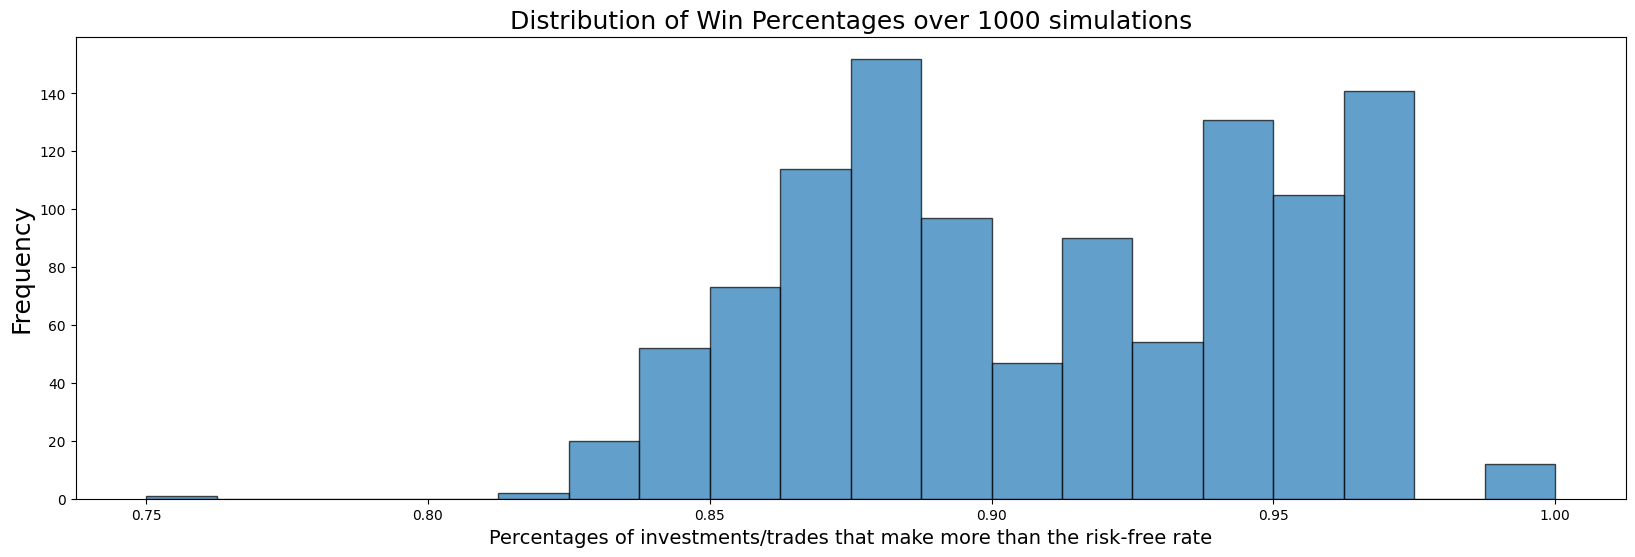

In [75]:
# Plot the distribution of ratios as a histogram
plt.figure(figsize=(20, 6))
plt.hist(ratios, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Win Percentages over 1000 simulations', fontsize=18)
plt.xlabel('Percentages of investments/trades that make more than the risk-free rate', fontsize=14)
plt.ylabel('Frequency', fontsize=18)

# Save the plot as a transparent, high-DPI SVG
plt.savefig('distribution_of_win_percentages.svg', format='svg', dpi=300, transparent=True)

# Display the plot
plt.show()

In [80]:
import pandas as pd
import yaml

def yaml_to_dataframe(yaml_file):
    """
    Reads a YAML file and converts it into a pandas DataFrame.
    
    Args:
        yaml_file (str): Path to the YAML file.
        
    Returns:
        pd.DataFrame: DataFrame representation of the YAML file.
    """
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    
    # Ensure the data is in a tabular structure
    if isinstance(data, list):  # If the YAML is a list of dictionaries
        df = pd.DataFrame(data)
    elif isinstance(data, dict):  # If the YAML is a dictionary of key-value pairs
        df = pd.DataFrame([data])
    else:
        raise ValueError("Unsupported YAML structure for conversion to DataFrame.")
    
    return df

# Example usage
if __name__ == "__main__":
    yaml_file_path = "mysol_export.yaml"  # Replace with your YAML file path
    df = yaml_to_dataframe(yaml_file_path)
    print(df)


                                           GDXReader  \
0  {'file': 'C:\Users\Sarang Sujit\Desktop\milp\m...   
1                                                NaN   

                                   PandasExcelWriter  
0                                                NaN  
1  {'file': 'C:\Users\Sarang Sujit\Desktop\milp\m...  


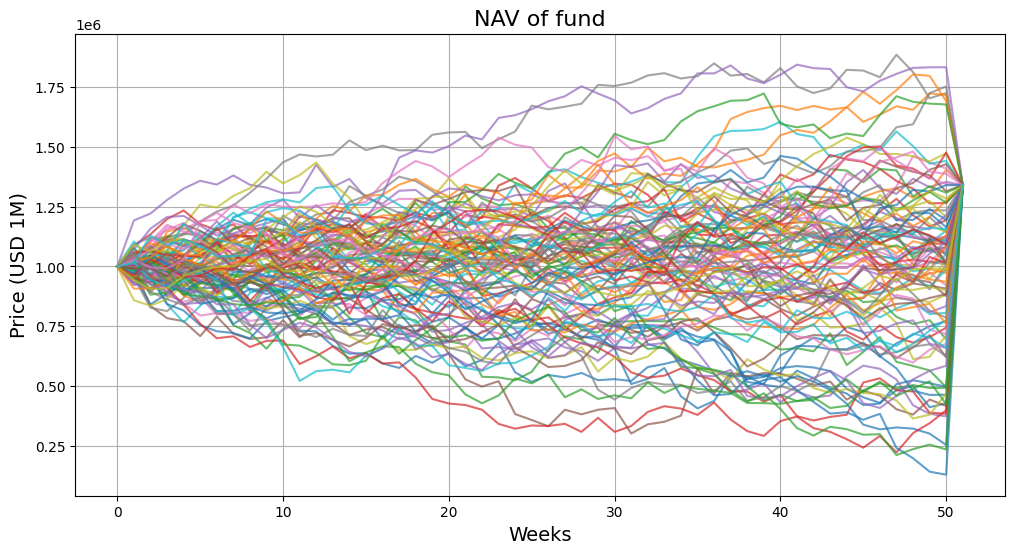

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
initial_value = 1_000_000  # Initial value of the price
final_value = 1_340_000   # Final value of the price
months = 52               # Time period in months
n_paths = 100              # Number of price paths to generate
volatility = 0.05         # Assumed volatility (5% monthly for example)

# Generate random paths
np.random.seed(42)  # For reproducibility
price_paths = []

for _ in range(n_paths):
    # Generate random monthly returns centered around 0 (with specified volatility)
    random_returns = np.random.normal(loc=0, scale=volatility, size=months)
    
    # Create the price path by cumulatively summing the random returns
    cumulative_returns = np.cumsum(random_returns)
    
    # Create the raw price path starting at 1M
    raw_prices = initial_value * (1 + cumulative_returns)
    
    # Force the path to start at 1M and end at 1.34M
    raw_prices = raw_prices - raw_prices[0] + initial_value  # Adjust to start at 1M
    raw_prices[-1] = final_value  # Force the last value to be 1.34M

    # Append the adjusted price path
    price_paths.append(raw_prices)

# Parameters for the plot
plt.figure(figsize=(12, 6))

# Plot each path in the price_paths list
for path in price_paths:
    plt.plot(path, alpha=0.7)

# Add titles and labels
plt.title('NAV of fund', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Price (USD 1M)', fontsize=14)

# Show grid
plt.grid(True)

# Save the figure as an SVG with high quality
plt.savefig("fund_nav_plot.svg", format="svg", dpi=300)

# Show the plot
plt.show()

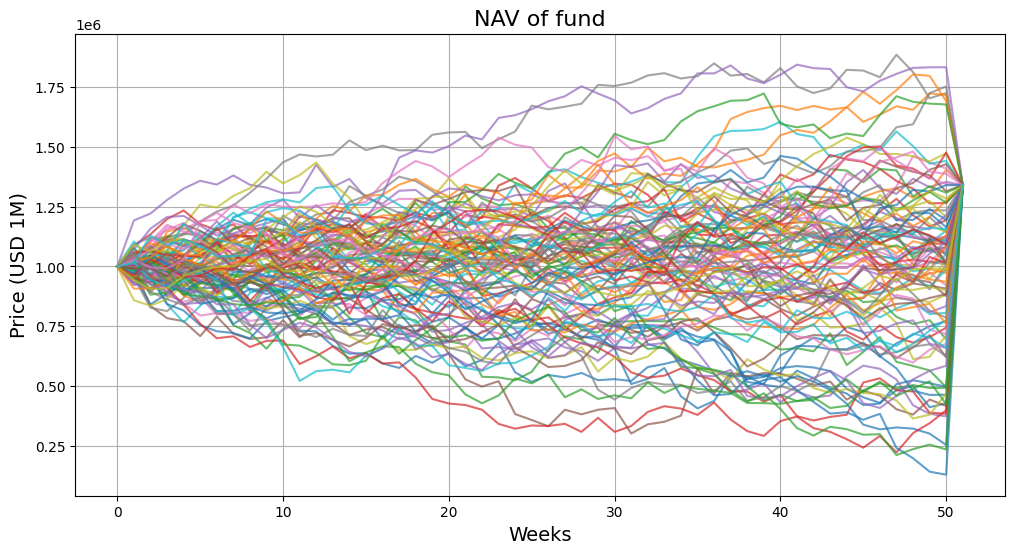

In [102]:
# Parameters for the plot
plt.figure(figsize=(12, 6))

# Plot each path in the price_paths list
for path in price_paths:
    plt.plot(path, alpha=0.7)

# Add titles and labels
plt.title('NAV of fund', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Price (USD 1M)', fontsize=14)

# Show grid
plt.grid(True)

# Save the figure as an SVG with transparent background
plt.savefig("fund_nav_plot.svg", format="svg", dpi=300, transparent=True)

# Show the plot
plt.show()